In [13]:
import collections
import itertools
import json
import os
import re
import glob
import operator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

In [14]:
def compute_accuracy(rows):
    levels = ['easy', 'medium', 'hard', 'extra', 'all']
    total = collections.defaultdict(int)
    exact = collections.defaultdict(int)
    for row in rows:
        exact[row['hardness']] += row['exact']
        exact['all'] += row['exact']
        total[row['hardness']] += 1
        total['all'] += 1
    
    result = {hardness: exact[hardness] / total[hardness]
              for hardness in levels}
    result = {**result, **{'{} count'.format(hardness): total[hardness] for hardness in levels}}
    return result

In [15]:
accuracy_per_run = collections.defaultdict(dict)
rows = []
for d in sorted(glob.glob('../logdirs/20190401/*')):
    exp_name = os.path.basename(d)
    output_from, emb, min_freq, att = re.match('output_from=([^,]+),emb=([^,]+),min_freq=(\d+),att=(\d+)', exp_name).groups()

    eval_paths = glob.glob(os.path.join(d, 'eval-val-step*-bs1.jsonl'))
    all_scores = []
    best = (0, 0)
    for eval_path in eval_paths:
        step = int(re.search('step(\d+)', eval_path).group(1))
        scores = json.load(open(eval_path))
        first_half_exact = compute_accuracy(scores['per_item'][:517])
        second_half_exact = compute_accuracy(scores['per_item'][517:])
        all_scores.append((step, scores['total_scores']['all']['exact'], first_half_exact['all'], second_half_exact['all']))
    
    all_scores.sort(key=operator.itemgetter(0))
    sorted_scores = sorted(all_scores, reverse=True, key=operator.itemgetter(1))
    rows.append((output_from, emb, min_freq, att, len(eval_paths)) + sorted_scores[0])
    accuracy_per_run[exp_name] = {
        'x': [s[0] for s in all_scores],
        'all': [s[1] for s in all_scores],
        '1/2': [s[2] for s in all_scores],
        '2/2': [s[3] for s in all_scores],
    }
    print(d)
    
df = pd.DataFrame(rows, columns=('output_from', 'emb', 'min_freq', 'att', 'num steps eval', 'step', 'acc', '1/2 acc', '2/2 acc'))

../logdirs/20190401/output_from=false,emb=bpemb-100k,min_freq=3,att=0
../logdirs/20190401/output_from=false,emb=bpemb-10k,min_freq=3,att=0
../logdirs/20190401/output_from=false,emb=glove-42B,min_freq=3,att=0
../logdirs/20190401/output_from=false,emb=glove-42B,min_freq=50,att=0
../logdirs/20190401/output_from=true,emb=bpemb-100k,min_freq=3,att=0
../logdirs/20190401/output_from=true,emb=bpemb-10k,min_freq=3,att=0
../logdirs/20190401/output_from=true,emb=glove-42B,min_freq=3,att=0
../logdirs/20190401/output_from=true,emb=glove-42B,min_freq=50,att=0


In [4]:
df

,output_from,emb,min_freq,att,num steps eval,step,acc,1/2 acc,2/2 acc
0,false,bpemb-100k,3,0,40,36100,0.362669,0.357834,0.367505
1,false,bpemb-10k,3,0,40,33100,0.352031,0.363636,0.340426
2,false,glove-42B,3,0,40,25100,0.350097,0.382979,0.317215
3,false,glove-42B,50,0,40,39100,0.376209,0.379110,0.373308
4,true,bpemb-100k,3,0,40,40000,0.334623,0.359768,0.309478
5,true,bpemb-10k,3,0,40,36100,0.336557,0.357834,0.315280
6,true,glove-42B,3,0,40,40000,0.334623,0.359768,0.309478
7,true,glove-42B,50,0,40,34100,0.353965,0.384913,0.323017


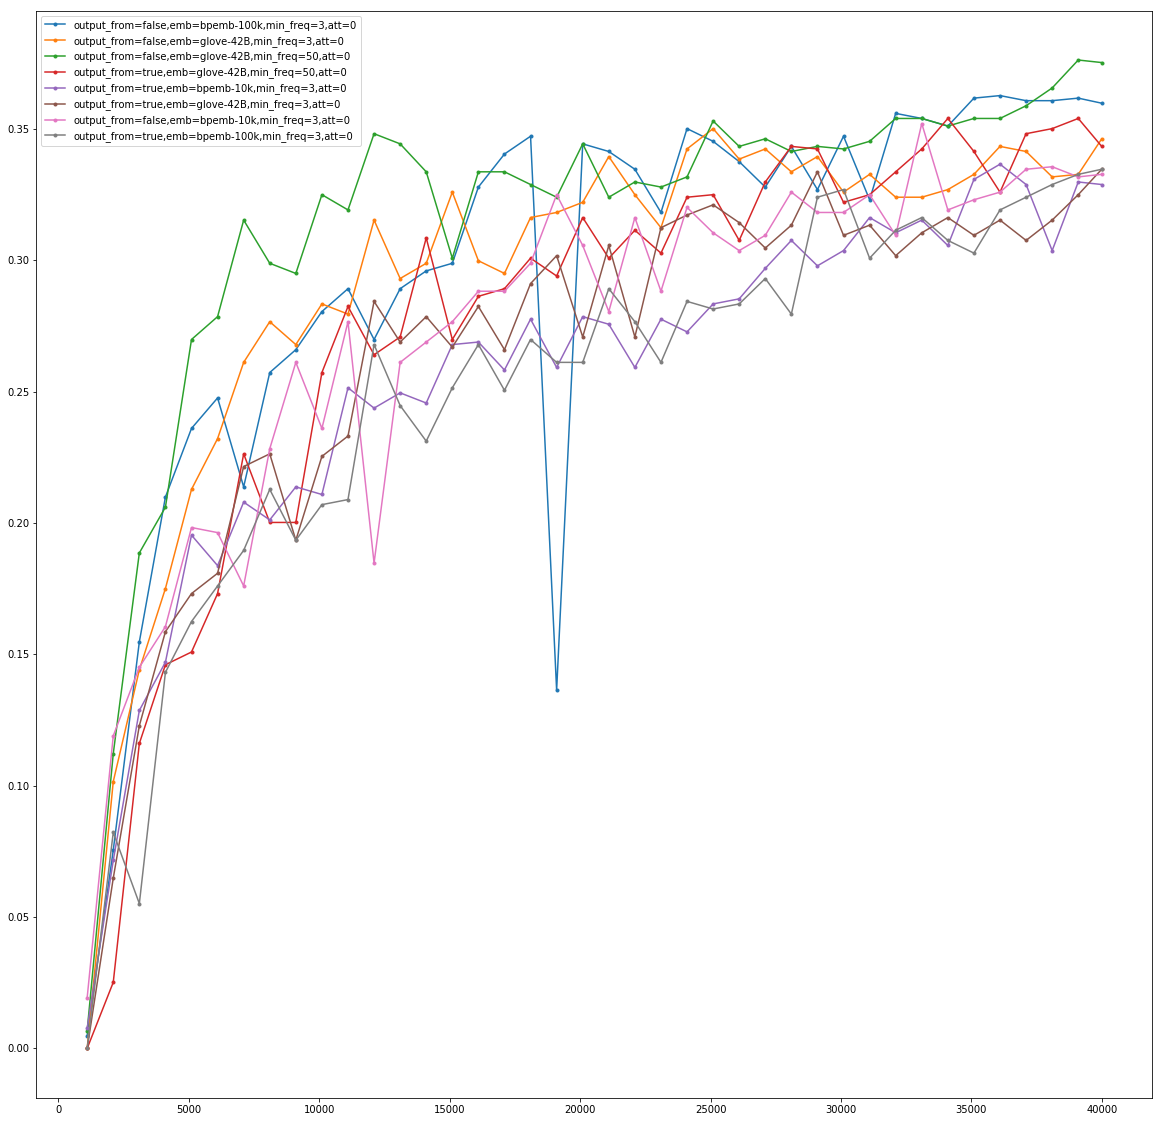

In [11]:
# See how accuracy varies over time
for k, v in sorted(accuracy_per_run.items():
    plt.plot(v['x'], v['all'], marker='.', label=k)
plt.legend()

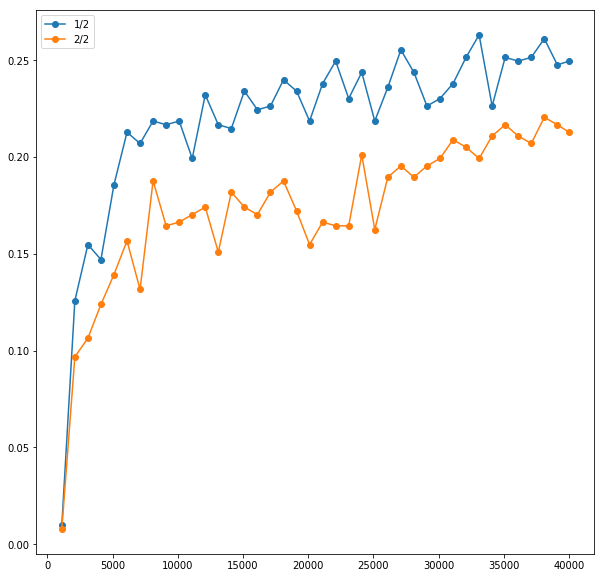

In [52]:
plt.plot(accuracy_per_run['false']['0']['x'], accuracy_per_run['false']['0']['1/2'], marker='o', label='1/2')
plt.plot(accuracy_per_run['false']['0']['x'], accuracy_per_run['false']['0']['2/2'], marker='o', label='2/2')
plt.legend()

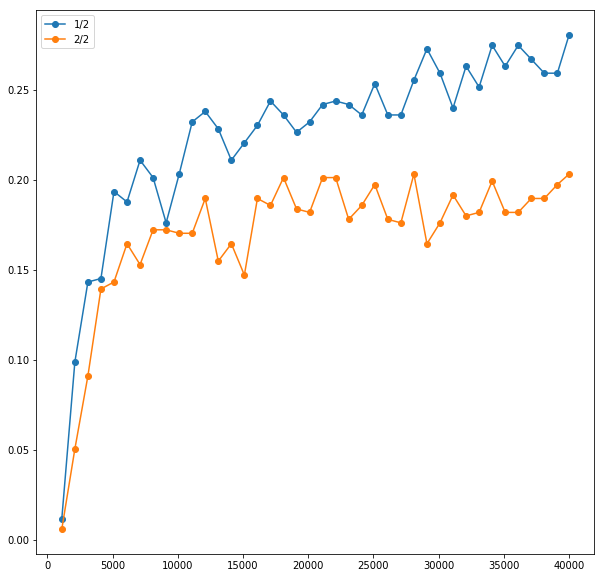

In [53]:
plt.plot(accuracy_per_run['false']['1']['x'], accuracy_per_run['false']['1']['1/2'], marker='o', label='1/2')
plt.plot(accuracy_per_run['false']['1']['x'], accuracy_per_run['false']['1']['2/2'], marker='o', label='2/2')
plt.legend()

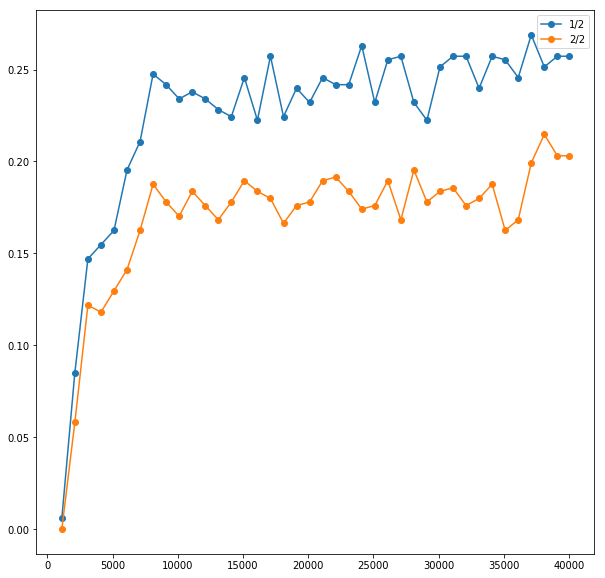

In [54]:
plt.plot(accuracy_per_run['false']['2']['x'], accuracy_per_run['false']['2']['1/2'], marker='o', label='1/2')
plt.plot(accuracy_per_run['false']['2']['x'], accuracy_per_run['false']['2']['2/2'], marker='o', label='2/2')
plt.legend()

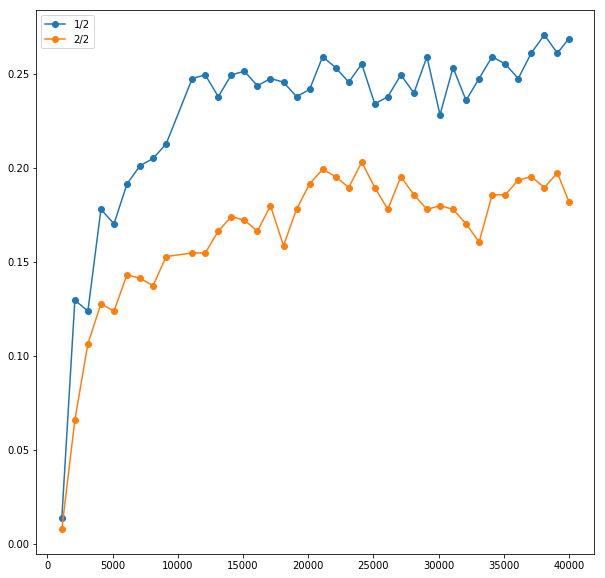

In [55]:
plt.plot(accuracy_per_run['false']['3']['x'], accuracy_per_run['false']['3']['1/2'], marker='o', label='1/2')
plt.plot(accuracy_per_run['false']['3']['x'], accuracy_per_run['false']['3']['2/2'], marker='o', label='2/2')
plt.legend()

In [12]:
for i in range(4):
    i = str(i)
    plt.plot(accuracy_per_run['true'][i]['x'], accuracy_per_run['true'][i]['y'], label=i)
plt.legend()

KeyError: '0'

In [74]:
# Vocabulary analysis
vocab = json.load(open('../data/spider-20190205/nl2code-0214-nofrom-notinc/enc_vocab.json'))
vocab_count = collections.OrderedDict((word, 0) for word in vocab)
for line in open('../data/spider-20190205/nl2code-0214-nofrom-notinc/enc/train.jsonl'):
    line = json.loads(line)
    for token in itertools.chain(line['question'], *line['tables'], *line['columns']):
        if token in vocab_count:
            vocab_count[token] += 1
        else:
            vocab_count['<UNK>'] += 1
vocab_by_occurrence = sorted(vocab_count.items(), key=operator.itemgetter(1), reverse=True)

In [75]:
vocab_by_occurrence[:50]

[('<type: text>', 139608),
 ('<type: number>', 133995),
 ('id', 73254),
 ('name', 37632),
 ('<type: time>', 12647),
 ('date', 11987),
 ('code', 11749),
 ('the', 11225),
 ('<UNK>', 10000),
 ('of', 9401),
 ('*', 8659),
 ('customer', 7817),
 ('number', 7171),
 ('details', 7159),
 ('type', 6861),
 ('year', 6851),
 ('state', 6397),
 ('country', 6313),
 ('address', 6133),
 ('product', 5948),
 ('city', 5941),
 ('paper', 5345),
 ('student', 5278),
 ('order', 4860),
 ('last', 4837),
 ('department', 4657),
 ('in', 4415),
 ('?', 4383),
 ('other', 4134),
 ('first', 4022),
 ('description', 3775),
 ('.', 3558),
 ('document', 3509),
 ('employee', 3368),
 ('author', 3210),
 ('staff', 3182),
 ('course', 3141),
 ('player', 3130),
 ('title', 2983),
 ('dataset', 2851),
 ('phrase', 2847),
 ('key', 2845),
 ('and', 2775),
 ('journal', 2725),
 ('What', 2672),
 ('are', 2669),
 ('phone', 2669),
 ('team', 2553),
 ('g', 2475),
 ('birth', 2410)]

In [76]:
vocab_by_occurrence[-50:]

[('minoring', 3),
 ('missions', 3),
 ('missouri', 3),
 ('moves', 3),
 ('neighbourhoods', 3),
 ('newest', 3),
 ('nuclear', 3),
 ('occurs', 3),
 ('outside', 3),
 ('payed', 3),
 ('populated', 3),
 ('practicing', 3),
 ('presently', 3),
 ('procedure', 3),
 ('producing', 3),
 ('prominent', 3),
 ('proteins', 3),
 ('provide', 3),
 ('ran', 3),
 ('ratio', 3),
 ('read', 3),
 ('reservation', 3),
 ('rock', 3),
 ('sanjeev', 3),
 ('science', 3),
 ('sesame', 3),
 ('shares', 3),
 ('showed', 3),
 ('showing', 3),
 ('square', 3),
 ('stayed', 3),
 ('steered', 3),
 ('string', 3),
 ('successfully', 3),
 ('surrounding', 3),
 ('taxes', 3),
 ('tournament', 3),
 ('traveled', 3),
 ('urban', 3),
 ('visitor', 3),
 ('ways', 3),
 ('weapons', 3),
 ('weights', 3),
 ('wisconsin', 3),
 ('workshops', 3),
 ('writers', 3),
 ('yet', 3),
 ('young', 3),
 ('<BOS>', 0),
 ('<EOS>', 0)]

In [84]:
dev = [json.loads(line) for line in open('../data/spider-20190205/nl2code-0214-nofrom-notinc/enc/val.jsonl')]

In [24]:
results = json.load(open('../logdirs/20190327/rerun,output_from=false,att=0/eval-val-step38100-bs1.jsonl'))

In [79]:
dev_vocab_counts = []
for line in open('../data/spider-20190205/nl2code-0214-nofrom-notinc/enc/val.jsonl'):
    line = json.loads(line)
    counts = []
    for token in itertools.chain(line['question'], *line['tables'], *line['columns']):
        if token in vocab_count:
            counts.append(vocab_count[token])
        else:
            counts.append(0)
    dev_vocab_counts.append(counts)

In [93]:
dev_unk_counts = []
for line in open('../data/spider-20190205/nl2code-0214-nofrom-notinc/enc/val.jsonl'):
    line = json.loads(line)
    info = {'question unks': 0, 'question count': 0,
            'tables unks': 0, 'tables count': 0,
            'columns unks': 0, 'columns count': 0}
    
    for token in line['question']:
        if token not in vocab_count:
            info['question unks'] += 1
        info['question count'] += 1
    for s in ('tables', 'columns'):
        for token in itertools.chain(*line[s]):
            if token not in vocab_count:
                info['{} unks'.format(s)] += 1
            info['{} count'.format(s)] += 1
    dev_unk_counts.append(info)

In [94]:
train_unk_counts = []
for line in open('../data/spider-20190205/nl2code-0214-nofrom-notinc/enc/train.jsonl'):
    line = json.loads(line)
    info = {'question unks': 0, 'question count': 0,
            'tables unks': 0, 'tables count': 0,
            'columns unks': 0, 'columns count': 0}
    
    for token in line['question']:
        if token not in vocab_count:
            info['question unks'] += 1
        info['question count'] += 1
    for s in ('tables', 'columns'):
        for token in itertools.chain(*line[s]):
            if token not in vocab_count:
                info['{} unks'.format(s)] += 1
            info['{} count'.format(s)] += 1
    train_unk_counts.append(info)

In [107]:
dev[0]['tables']

[['stadium'], ['singer'], ['concert'], ['singer', 'in', 'concert']]

In [83]:
dev_unk_counts[0]

{'columns count': 55,
 'columns unks': 5,
 'question count': 7,
 'question unks': 0,
 'tables count': 6,
 'tables unks': 4}

In [100]:
dev_no_schema_unk_idx = [i for i, c in enumerate(dev_unk_counts) if c['columns unks'] == 0 and c['tables unks'] == 0]

In [103]:
dev_no_question_unk_idx = [i for i, c in enumerate(dev_unk_counts) if c['question unks'] == 0]

In [101]:
compute_accuracy(results['per_item'][i] for i in dev_no_schema_unk_idx)

{'all': 0.2222222222222222,
 'all count': 18,
 'easy': 0.6666666666666666,
 'easy count': 3,
 'extra': 0.0,
 'extra count': 4,
 'hard': 0.0,
 'hard count': 3,
 'medium': 0.25,
 'medium count': 8}

In [106]:
dev[411]

{'column_to_table': {'0': None,
  '1': 0,
  '10': 2,
  '11': 2,
  '12': 2,
  '2': 0,
  '3': 0,
  '4': 0,
  '5': 1,
  '6': 1,
  '7': 1,
  '8': 1,
  '9': 2},
 'columns': [['<type: text>', '*'],
  ['<type: number>', 'museum', 'id'],
  ['<type: text>', 'name'],
  ['<type: number>', 'num', 'of', 'staff'],
  ['<type: text>', 'open', 'year'],
  ['<type: number>', 'customer', 'id'],
  ['<type: text>', 'name'],
  ['<type: number>', 'level', 'of', 'membership'],
  ['<type: number>', 'age'],
  ['<type: number>', 'museum', 'id'],
  ['<type: text>', 'customer', 'id'],
  ['<type: number>', 'num', 'of', 'ticket'],
  ['<type: number>', 'total', 'spent']],
 'foreign_keys': {'10': 5, '9': 1},
 'foreign_keys_tables': {'2': [0, 1]},
 'primary_keys': [9, 9, 9],
 'question': ['How',
  'many',
  'visitors',
  'below',
  'age',
  '30',
  'are',
  'there',
  '?'],
 'table_bounds': [1, 5, 9, 13],
 'table_to_columns': {'0': [1, 2, 3, 4],
  '1': [5, 6, 7, 8],
  '2': [9, 10, 11, 12]},
 'tables': [['museum'], ['cus

In [104]:
compute_accuracy(results['per_item'][i] for i in dev_no_question_unk_idx)

{'all': 0.3514644351464435,
 'all count': 239,
 'easy': 0.45161290322580644,
 'easy count': 62,
 'extra': 0.18181818181818182,
 'extra count': 33,
 'hard': 0.34285714285714286,
 'hard count': 35,
 'medium': 0.3486238532110092,
 'medium count': 109}

In [102]:
compute_accuracy(results['per_item'])

{'all': 0.24081237911025144,
 'all count': 1034,
 'easy': 0.344,
 'easy count': 250,
 'extra': 0.08823529411764706,
 'extra count': 170,
 'hard': 0.21839080459770116,
 'hard count': 174,
 'medium': 0.25,
 'medium count': 440}

In [98]:
len(dev_unk_counts)

1034

In [96]:
len([c for c in train_unk_counts if c['columns unks'] == 0 and c['tables unks'] == 0])

4452

In [97]:
len(train_unk_counts)

8659